In [7]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.3)

from agents import Agent
from mouselab import MouselabEnv
from distributions import Normal, Categorical
from policies import FixedPlanPolicy, LiederPolicy
from evaluation import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
from scipy.stats import norm
def discrete_normal(mu, sigma, discretization):
    d = norm(0, sigma)
    vals = np.linspace(-2*sigma, 2*sigma, discretization)
    delta = vals[1] - vals[0]
    bins = np.array((-np.inf, *(vals[1:] - delta/2), np.inf))
    probs = np.diff(d.cdf(bins))
    return Categorical(vals, probs)

def make_env(depth, cost, discretization=False, ground_truth=False):
    """Returns a MouselabEnv with branching factor 2 and given depth and cost.
    
    If `ground_truth` is True, the reward observed at a given node will be
    constant across runs on this env. This reduces variance of the return."""
    sigma = 1
    reward = (discrete_normal(0, sigma, discretization)
              if discretization else Normal(0, sigma))
    env = MouselabEnv(2, depth, reward=reward, cost=cost)
    if ground_truth:
        env.ground_truth = np.array([0, *reward.sample(len(env.tree) - 1)])
    return env

def make_envs(depth, cost, discretization=None, ground_truth=None, n=100):
    # Note: ground_truth can be an int in which case it acts as a random seed.
    if ground_truth is not None:
        np.random.seed(ground_truth)
        envs = [make_env(depth, cost, discretization, True) for _ in range(n)]
        # This allows every environment to rely on the same cache for sampling
        # from rewards.
        for e in envs:
            e.init = envs[0].init
        return envs
    else:
        return [make_env(depth, cost, discretization, False)] * n

In [3]:
pol = LiederPolicy([1, 1, 1, 1, 1])
env = make_env(3, .1)
agent = Agent()
agent.register(env)
agent.register(pol)

# agent.run_episode()
# %prun agent.run_episode()

In [14]:
from distributions import *
from evaluation import evaluate
envs = make_envs(3, .1, n=10, ground_truth=None)
# evaluate(pol, envs)s
def test():
    print(evaluate(pol, envs).util.mean())
    
%time test()

1.02725084252
CPU times: user 2.21 s, sys: 233 ms, total: 2.44 s
Wall time: 2.46 s


In [10]:
from distributions import *
a = Normal(0, 1)
b = Normal(0, 1)
ab = smax((a, b))
x = ab + a
smax((x, ab)).expectation()

[-0.97113326  0.38492906 -0.53265738 ...,  0.89398759  1.46710868
 -0.52849598]


0.96989876465739067

1.17578333884
CPU times: user 103 ms, sys: 1.93 ms, total: 105 ms
Wall time: 108 ms


AssertionError: 

In [11]:
test()

add number
init 4
add number
init 0
3.70845118935


In [28]:
train_envs = make_envs(5, .1, ground_truth=True, n=200)
pol, result = bo_policy(train_envs, max_cost=10, normalize_voi=False,
                        n_calls=100, verbose=1, n_jobs=1, return_result=True)

from skopt.plots import plot_convergence, plot_evaluations, plot_objective
plot_convergence(result)

TypeError: unorderable types: NoneType() > int()

In [26]:
def run_params(depth=3, cost=.1):
    print('train', cost)
    train_envs = make_envs(depth, cost, discretization=4, n=200, ground_truth=True)
    env = train_envs[0]
    term_action = env.term_action
    policies = {
        # 'BO': bo_policy(train_envs, max_cost=len(env.tree), n_calls=30, n_jobs=40),
        # 'BO_unnorm': bo_policy(train_envs, normalize_voi=False, 
        #                        max_cost=100, n_calls=30, n_jobs=40),
        'BO': pol,
        'myopic': LiederPolicy([1, 1, 0, 0, 1]),
        # 'optimal': optimal_policy(env),
        'full': FixedPlanPolicy(range(1, term_action+1)),
        'none': FixedPlanPolicy([term_action]),
    }
    test_envs = make_envs(depth, cost, n=500, ground_truth=True)
    def test():
        print('test', cost)
        for name, policy in policies.items():
            df = evaluate(policy, envs=test_envs)
            df['agent'] = name
            df['depth'] = depth
            df['cost'] = cost
            yield df
    return pd.concat(test())

df = run_params(cost=.1)

train 0.1
test 0.1


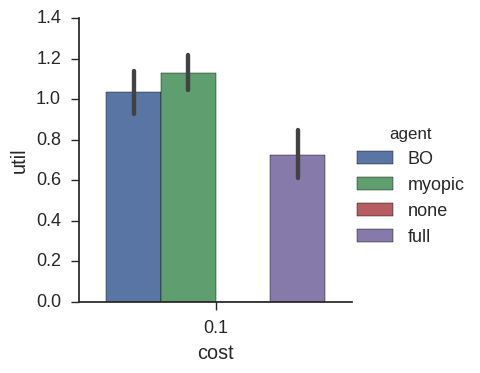

In [28]:
sns.set_style('ticks')
sns.factorplot('cost', 'util', hue='agent', data=df, kind='bar')
# plt.ylim(-2, 2)

(-2, 2)

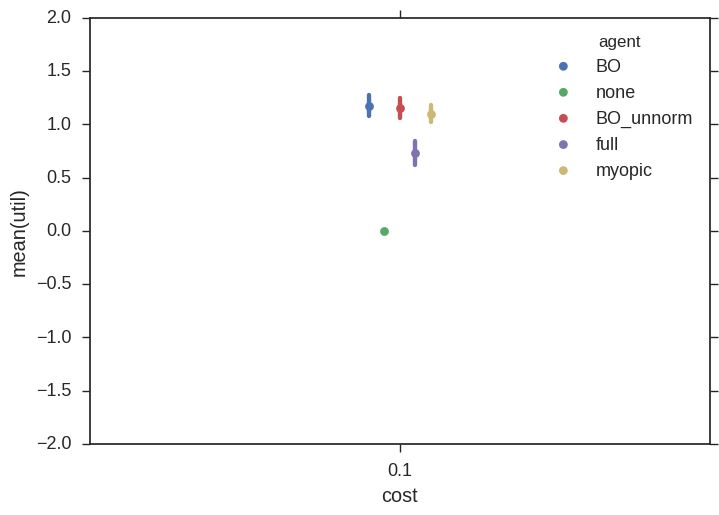

In [5]:
sns.set_style('ticks')
sns.pointplot('cost', 'util', hue='agent', data=df, markers='.', size=(4,4), 
              dodge=.1)
plt.ylim(-2, 2)

In [ ]:
# sns.factorplot('agent', 'util', data=df, 
               order=['none', 'one', 'two', 'full', 'BO'], 
               kind='bar')

In [86]:
empirical = df.query('agent == "BO"').util
# print('BO = {:.1f}'.format(-result.fun))
print('empirical ~ $N({:.1f}, {:.1f}^2)$'.format(empirical.mean(), empirical.std()))

empirical ~ $N(14.9, 14.9^2)$


In [26]:
empirical = df.query('agent == "BO"').util
print('BO = {:.1f}'.format(-result.fun))
print('empirical ~ $N({:.1f}, {:.1f}^2)$'.format(empirical.mean(), empirical.std()))

BO = 14.1
empirical ~ $N(12.0, 11.9^2)$


12.425000000000001

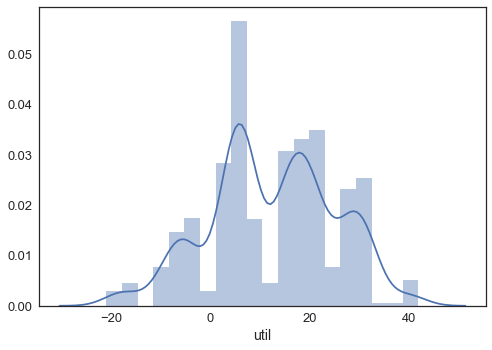

In [62]:
sns.distplot(df.query('agent == "BO"').util)
df.query('agent == "BO"').util.mean()

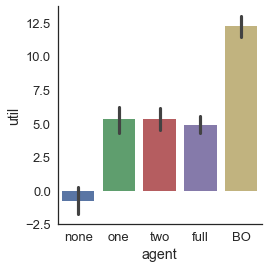

In [12]:
sns.factorplot('agent', 'util', data=df, 
               order=['none', 'one', 'two', 'full', 'BO'], 
               kind='bar')